# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost

%matplotlib inline

vit = pd.read_csv('../data/no-show-300k.csv')

# Transformations required for modeling
def transform_vitoria(df):
    new_names = ['age', 'gender', 'app_registration', 'app_date', 'week_day', 'show_up',
                 'diabetes', 'alcoholism', 'hypertension', 'handicap', 'smokes', 
                 'monetary_help', 'tuberculosis', 'sms_reminder', 'days_to_appointment']
    new_order = ['age', 'gender', 'week_day', 'days_to_appointment', 'diabetes', 'alcoholism', 
                 'hypertension', 'handicap', 'smokes', 'monetary_help', 'tuberculosis', 
                 'sms_reminder', 'show_up']
    df.columns = new_names
    df = df.loc[:, new_order]
    df.loc[:, 'week_day'] = df.loc[:, 'week_day'].str.lower()
    df.loc[:, 'gender'] = df.loc[:, 'gender'].str.lower()
    df.loc[:, 'days_to_appointment'] = df.loc[:, 'days_to_appointment'] * -1
    df = df.replace({'show_up': {'Show-Up': 1, 'No-Show': 0, '2': 0}})
    
    return df

vit = transform_vitoria(vit)
vit.head()

,age,gender,week_day,days_to_appointment,diabetes,alcoholism,hypertension,handicap,smokes,monetary_help,tuberculosis,sms_reminder,show_up
0,19,m,wednesday,29,0,0,0,0,0,0,0,0,1
1,24,f,wednesday,1,0,0,0,0,0,0,0,0,1
2,4,f,tuesday,1,0,0,0,0,0,0,0,0,1
3,5,m,thursday,15,0,0,0,0,0,0,0,1,1
4,38,m,tuesday,6,0,0,0,0,0,0,0,1,1


# Outlier Removal

In [42]:
log_feature = np.log(vit['days_to_appointment'])
Q1 = np.percentile(log_feature, 25)
Q3 = np.percentile(log_feature, 75)
step = (Q3 - Q1) * 1.5

log_feature_without_outliers = log_feature[log_feature <= Q3 + step]
print('Outliers removed: ')
print(len(log_feature) - len(log_feature_without_outliers))
vit.loc[log_feature > Q3 + step, 'days_to_appointment'].describe()

Outliers removed: 
96


count     96.000000
mean     277.937500
std       38.398962
min      224.000000
25%      238.750000
50%      279.500000
75%      301.000000
max      398.000000
Name: days_to_appointment, dtype: float64

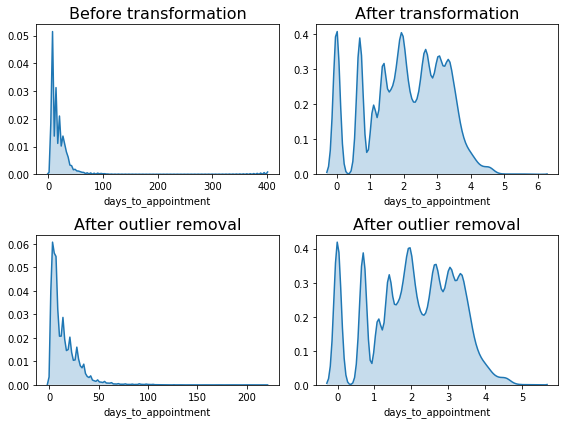

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

sns.distplot(vit['days_to_appointment'], hist=False, kde_kws={'shade': True}, ax=ax[0, 0])
ax[0, 0].set_title('Before transformation', fontsize=16)

sns.distplot(log_feature, hist=False, kde_kws={'shade': True}, ax=ax[0, 1])
ax[0, 1].set_title('After transformation', fontsize=16)

sns.distplot(log_feature_without_outliers, hist=False, kde_kws={'shade': True}, ax=ax[1, 1])
ax[1, 1].set_title('After outlier removal', fontsize=16)

sns.distplot(vit.loc[log_feature <= Q3 + step, 'days_to_appointment'], hist=False, kde_kws={'shade': True}, ax=ax[1, 0])
ax[1, 0].set_title('After outlier removal', fontsize=16)

fig.tight_layout()

# Feature Selection

In [48]:
with open('../data/features_selected', 'r') as f:
    features_selected = [line.strip() for line in f.readlines()]
    
minimal_data = vit.loc[log_feature <= Q3 + step, features_selected + ['show_up']].reset_index(drop=True)

# Normalization

In [57]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler().fit(minimal_data)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [62]:
a = normalizer.transform(minimal_data)

In [58]:
# Export
# with open('../data/normalizer', 'wb') as f:
#     pickle.dump(normalizer, f)

# Train Test Split

In [54]:
# Saves minimal data
from sklearn.model_selection import train_test_split

X = minimal_data.drop('show_up', axis=1)
y = minimal_data.loc[:, 'show_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cluster_train = X_train.assign(show_up = y_train).reset_index(drop=True)
cluster_test = X_test.assign(show_up = y_test).reset_index(drop=True)

In [55]:
import pickle

minimal_data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'cluster_train': cluster_train,
    'cluster_test': cluster_test
}

# pickle.dump(minimal_data_dict, open("../data/minimal_data_dict", "wb"))
# minimal_data.to_csv('../data/minimal_data.csv', index=False)

# Final import after preprocessing

In [73]:
import pandas as pd
import pickle

minimal_data = pd.read_csv('../data/minimal_data.csv')
X = minimal_data.drop('show_up', axis=1)
y = minimal_data.loc[:, 'show_up']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
cluster_train = X_train.assign(show_up = y_train).reset_index(drop=True)
cluster_test = X_test.assign(show_up = y_test).reset_index(drop=True)

with open("../data/normalizer", "rb") as f:
    normalizer = pickle.load(f)
    
cluster_train_norm = normalizer.transform(cluster_train)
cluster_test_norm = normalizer.transform(cluster_test)

In [76]:
cluster_train_norm

array([[ 0.4173913 ,  0.00460829,  0.        ,  1.        ],
       [ 0.30434783,  0.        ,  0.        ,  1.        ],
       [ 0.55652174,  0.00460829,  0.        ,  0.        ],
       ..., 
       [ 0.22608696,  0.02304147,  0.        ,  0.        ],
       [ 0.27826087,  0.00460829,  0.        ,  1.        ],
       [ 0.66086957,  0.02764977,  0.        ,  1.        ]])